# Model of predicting academic success of high school students

This section of the analysis will attempt to construct a model to predict:

* G3 - final grade (numeric: from 0 to 20, output target) final school grade
* overall_grade  - a combination of G1, G2 and G3

G1 - first period grade (numeric: from 0 to 20)
G2 - second period grade (numeric: from 0 to 20)
G3 - final grade (numeric: from 0 to 20, output target)

In [353]:
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
%matplotlib inline 
#to allow plots to render in the notebook

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({'font.size': 18})

In [354]:
data = pd.read_csv('../input/student_math_por_formatted.csv')
print(data.shape)
print(data.columns)

(1044, 48)
Index(['Unnamed: 0', 'school', 'sex', 'age', 'address', 'famsize', 'Pstatus',
       'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'schoolsup',
       'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet',
       'romantic', 'famrel', 'freetime', 'goout', 'subject', 'Mjob_at_home',
       'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher',
       'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services',
       'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other',
       'reason_reputation', 'guardian_father', 'guardian_mother',
       'guardian_other', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2',
       'G3'],
      dtype='object')


# Modelling




In [98]:
cols = data.columns.tolist()
#moving the grades and alcohol variables to the end of the list
cols = cols[:22] + cols[29:] + cols[22:29] 
data = data[cols]
data.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid',
       'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'subject', 'Mjob_at_home', 'Mjob_health',
       'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home',
       'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher',
       'reason_course', 'reason_home', 'reason_other', 'reason_reputation',
       'guardian_father', 'guardian_mother', 'guardian_other', 'Dalc', 'Walc',
       'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

## Dropping the obvious

Initially, an $r^{2}$ score hovering around 85% would be encouraging.

However, I question the usefulness of having G1 and G2 in the model. It is essentially amounting to: "students who do well in earlier tests tend to do well in later tests."

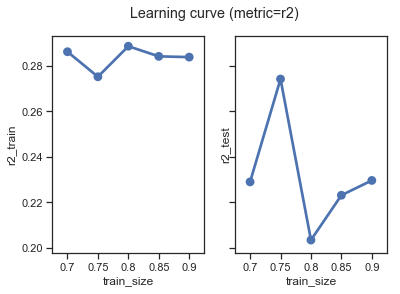

In [100]:
X = data.iloc[:, :-3] #dropping G1 and G2
y = data.iloc[:, -1:]

#re-run of the above model with G1 and G2 absent
plot_learning_curve(check_linreg_learning_curve);

## Learning Curves

With relatively small datasets like this, it is important to see how much the small sample size is contributing to underfit or overfit.

Learning curves will be plotted to visualise this using training proportions of
* 70%
* 75%
* 80%
* 85%
* 90%

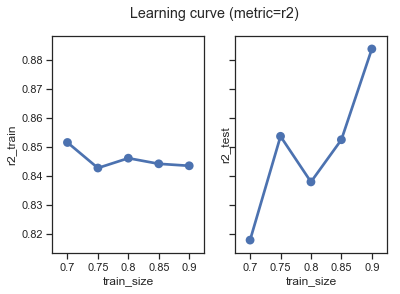

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics.regression import r2_score
from sklearn.feature_selection import RFE

train_sizes = [0.7, 0.75, 0.8, 0.85, 0.9]

X = data.iloc[:, :-1]
y = data.iloc[:, -1:]

def plot_learning_curve(algo):
    
    r2_scores = [algo(train_size) for train_size in train_sizes]
    r2_df = pd.DataFrame(data=r2_scores)
    
    f, (ax1, ax2) = plt.subplots(1,2, sharey=True)
    sns.pointplot("train_size", "r2_train",  data=r2_df, ax=ax1)
    sns.pointplot("train_size", "r2_test",  data=r2_df, ax=ax2)
    f.suptitle("Learning curve (metric=r2)")
    
    return r2_df

def check_linreg_learning_curve(train_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=0)

    linreg = LinearRegression().fit(X_train, y_train)
    r2_train = linreg.score(X_train, y_train)
    r2_test = linreg.score(X_test, y_test)

    return {"train_size": train_size, "r2_train" : r2_train, "r2_test" : r2_test}

plot_learning_curve(check_linreg_learning_curve);

And now our model looks much less impressive. The low performance on both train and test sets suggest a high bias.

Given that our problem isn't overfitting, a Decision Tree Regression might be appropriate.

## Decision Tree Regression

,r2_test,r2_train,train_size
0,0.184683,0.151918,0.70
1,0.188719,0.151443,0.75
2,0.122064,0.164349,0.80
3,0.187187,0.157159,0.85
4,0.190171,0.158189,0.90


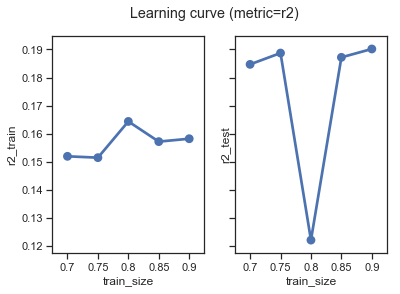

In [101]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

def check_decreg_learning_curve(train_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=0)
    
    parameters = {'max_depth' : [1,5] }

    y_train = y_train.G3.values.reshape(-1,)
    decreg = DecisionTreeRegressor()
    decreg = GridSearchCV(decreg, parameters).fit(X_train, y_train)
    
    r2_train = decreg.score(X_train, y_train)
    r2_test = decreg.score(X_test, y_test)

    return {"train_size": train_size, "r2_train" : r2_train, "r2_test" : r2_test}

plot_learning_curve(check_decreg_learning_curve)

No, that's even worse.

To increase performance, we could:

* increase the sample size.
* increase the number of features.
* introduce polynomial features.

Play around with regularisation?


## Linear Regression with Polynomial Features

0

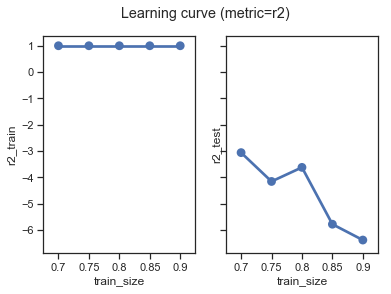

In [102]:
from sklearn.preprocessing import PolynomialFeatures

def polylinreg(train_size, degree):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=0)
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)

    linreg = LinearRegression().fit(X_train_poly, y_train)
    r2_train = linreg.score(X_train_poly, y_train)
    r2_test = linreg.score(X_test_poly, y_test)

    return {"degree" : degree, "train_size": train_size, "r2_train" : r2_train, "r2_test" : r2_test}

degrees = [2,3] #if I try for degree>4 I get an "array is too big" or memory error

def check_polylinreg_learning_curve(train_size):
    data = [polylinreg(train_size, degree) for degree in degrees]
    data = pd.DataFrame(data=data)
    max_test = data.loc[data.r2_test.idxmax()]
    return {
            "degree" : max_test.degree, 
            "train_size": max_test.train_size, 
            "r2_train" : max_test.r2_train, 
            "r2_test" : max_test.r2_test
    }
    

r2_df = plot_learning_curve(check_polylinreg_learning_curve);0


At first glance, you may feel like there is something wrong with the charts.

The introduction of the polynomial features resulted in extreme overfitting with r2_train scores hitting 1.0 for degree 3 (around 0.95 for degree 2) and r2_test scores consistently below 0 (with degree 2 performance even worse).

In [103]:
r2_df

,degree,r2_test,r2_train,train_size
0,3.0,-3.056374,1.0,0.70
1,3.0,-4.150896,1.0,0.75
2,3.0,-3.616266,1.0,0.80
3,3.0,-5.773750,1.0,0.85
4,3.0,-6.374223,1.0,0.90
